# 4.2. Concise Implementation of Multilayer Perceptron with csv (regression)

MLP로 regression을 하는 예제를 csv파일을 불러와서 진행하는 예제입니다. 
본 예제의 csv파일은 jhu covid-19 csv파일을 임의로 training, validation으로 나누어 불러와 
일부 column들로 feature vector를 구성하여 input으로 하고, 마지막에서 두 번째 column을 output으로 하여 regression을 진행하는 것을 보여줍니다.

예측하려는 날짜의 2주일 전까지 수집된 4주 간의 데이터를 이용하여, 예측하려는 날짜의 누적확진자 숫자를 예측하도록 한 것입니다. L, 28을 바꾸어 주면 다른 구간의 데이터로 예측을 해볼 수 있습니다. 

또한, 나라마다 숫자들의 범위가 너무 차이가 크기 때문에 log를 취하여 훈련을 진행하였음을 주의하여 주세요.


이 실습은 단지 csv파일을 활용하는 예제를 보여주는 것이니 적절한 데이터와 target(label)을 csv파일로 구성하여 각자 실습을 진행하면 됩니다.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

colab을 사용하는 경우에는 google drive를 mount하도록 합니다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
root = '/content/drive/My Drive/hufs'

In [0]:
import pandas as pd


임의로 만들어 놓은 csv파일을 웹에서 가져오도록 하였으나, 실습을 진행할 때에는 각자 준비한 csv파일을 구글드라이브에 저장하여 불러오면 됩니다. 

In [5]:
data_train = pd.read_csv('https://raw.githubusercontent.com/hufsbme/T10402101/master/ch4_multilayer_perceptron/sample_train.csv')
print(data_train.shape)
data_valid = pd.read_csv('https://raw.githubusercontent.com/hufsbme/T10402101/master/ch4_multilayer_perceptron/sample_valid.csv')
print(data_valid.shape)

(188, 105)
(40, 105)


불러온 csv파일은 제대로 읽혀지는지 확인을 하도록 합니다.

In [6]:
data_train[:5]

,Unnamed: 0,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2002/01/20,2002/02/20,2002/03/20,2002/04/20,2002/05/20,2002/06/20,2002/07/20,2002/08/20,2002/09/20,2002/10/20,2002/11/20,2002/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,2004/01/20,2004/02/20,2004/03/20,2004/04/20,2004/05/20,2004/06/20,2004/07/20,2004/08/20,2004/09/20,2004/10/20,2004/11/20,2004/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,label
0,0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,3
1,1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,2
2,2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,3
3,3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,2
4,4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,1


아래에서 사용한 index들은 제가 준비한 csv에 맞게 되어 있는 것이므로, 각자의 데이터의 원하는 column들을 가져올 수 있도록 수정하여야 합니다.

In [0]:
L= - 14
features, labels, country = data_train.iloc[:,L-28:L], data_train.iloc[:,-2], data_train.iloc[:,[1,2]]
features_valid, labels_valid, country_valid = data_valid.iloc[:,L-28:L], data_valid.iloc[:,-2], data_valid.iloc[:,[1,2]]


마찬가지로 log를 취하고, 그 전에 .1을 더하거나 한 행위도 제가 준비한 데이터의 특성을 고려하여 임의로 진행을 한 것이므로 각자의 데이터에 맞게 전처리 과정을 진행해 주어야 합니다.

classification과는 다르게 label을 flaoting variable로 가져가는 것을 주의해 주세요.

In [8]:
features = (torch.tensor(np.log(features.values+0.1)).float())
features_valid = (torch.tensor(np.log(features_valid.values+0.1)).float())
labels = torch.tensor(np.log(labels+0.1)).reshape(-1,1).float()
labels_valid = torch.tensor(np.log(labels_valid+0.1)).reshape(-1,1).float()

print(features.shape)
print(labels.shape)
print(features_valid.shape)
print(labels_valid.shape)

fsize = (features.shape)[-1]
fsize


torch.Size([188, 28])
torch.Size([188, 1])
torch.Size([40, 28])
torch.Size([40, 1])


28

In [9]:
print(features[4])
print(labels[4])

tensor([0.0953, 0.7419, 0.7419, 1.1314, 1.1314, 1.1314, 1.4110, 1.4110, 1.6292,
        1.9601, 1.9601, 1.9601, 2.0919, 2.0919, 2.0919, 2.3125, 2.6462, 2.7788,
        2.8391, 2.9497, 2.9497, 2.9497, 2.9497, 2.9497, 2.9497, 2.9497, 2.9497,
        2.9497])
tensor([3.2995])


Hyperparameter들은 각자의 문제에 맞추어 설정해 주어야 합니다.
MLP의 layer개수 및 node의 숫자도 각자의 문제에 맞추어서 변경하도록 합니다.

In [0]:
# setting hyper-parameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10000
num_workers = 0

# defining data_iter, linreg. model, loss, sgd
train_iter = DataLoader(dataset=TensorDataset(features,labels),batch_size=batch_size,shuffle=True) 
valid_iter = DataLoader(dataset=TensorDataset(features_valid,labels_valid),batch_size=batch_size,shuffle=False) 

In [11]:
# defining model
net = nn.Sequential(
    nn.Linear(fsize,fsize*8),
    nn.ReLU(),    
    nn.Linear(fsize*8,fsize),
    nn.ReLU(),    
    nn.Linear(fsize,1)
    )
# parameter initialization
torch.nn.init.normal_(net[0].weight,std=0.01)
torch.nn.init.normal_(net[2].weight,std=0.01)
torch.nn.init.normal_(net[4].weight,std=0.01)
# loss function and algorithm
loss = torch.nn.MSELoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd

# display model
net

Sequential(
  (0): Linear(in_features=28, out_features=224, bias=True)
  (1): ReLU()
  (2): Linear(in_features=224, out_features=28, bias=True)
  (3): ReLU()
  (4): Linear(in_features=28, out_features=1, bias=True)
)

## Model Training
model을 훈련하면서 train loss, train accuracy, test accuracy를 관찰합니다.
바로 위의 cell의 hyperparameter들을 바꿔가면서 결과를 비교해 봅니다.


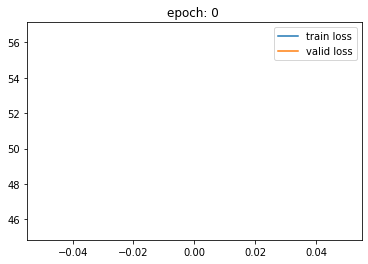

train loss:  45.40693155924479
valid loss:  56.57489776611328


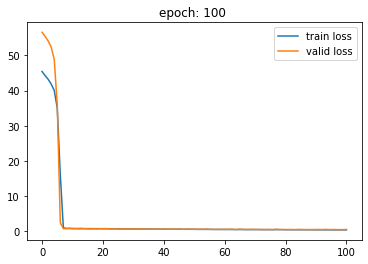

train loss:  0.3600333531697591
valid loss:  0.4946650564670563


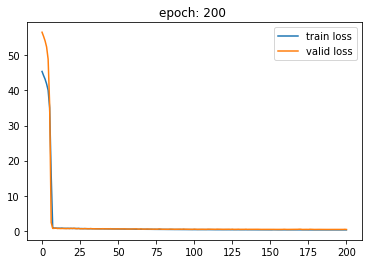

train loss:  0.28217679262161255
valid loss:  0.39310088753700256


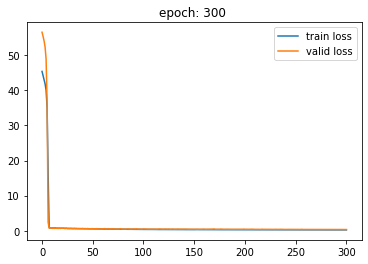

train loss:  0.22552130619684854
valid loss:  0.3301929831504822


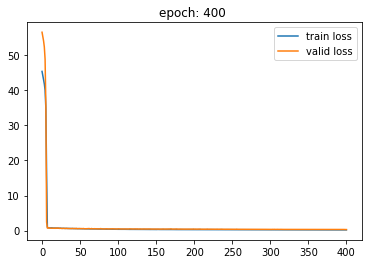

train loss:  0.1831579009691874
valid loss:  0.28283047676086426


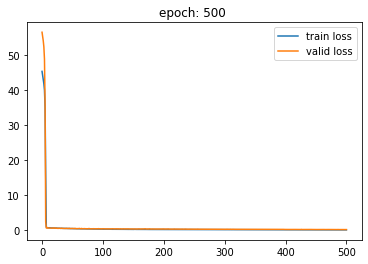

train loss:  0.15971887111663818
valid loss:  0.24905896186828613


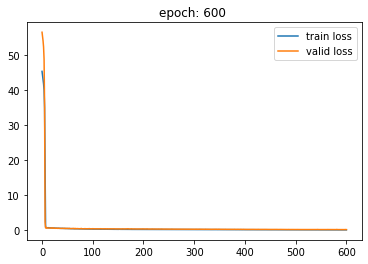

train loss:  0.14376644293467203
valid loss:  0.22823448479175568


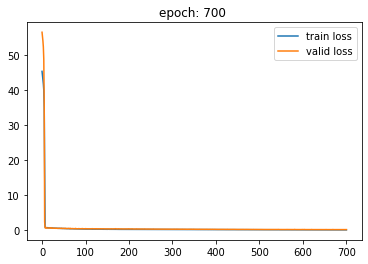

train loss:  0.13145785530408224
valid loss:  0.21983617544174194


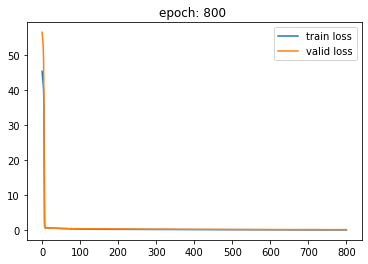

train loss:  0.12400420506795247
valid loss:  0.20416739583015442


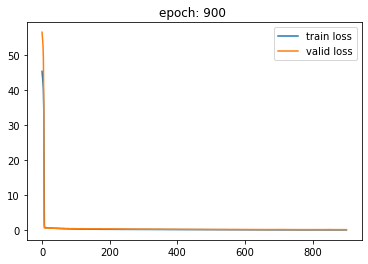

train loss:  0.12057899435361226
valid loss:  0.1985081136226654


In [12]:
# training the model
loss_train = np.array([])
loss_valid = np.array([])
for epoch in range(1000):
  i=0
  l_epoch = 0
  for X,y in train_iter:
    i=i+1
    y_hat=net(X)
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()  

  loss_train = np.append(loss_train,l_epoch.detach().numpy()/i)

  i=0
  l_epoch = 0
  for X,y in valid_iter:
    i=i+1
    y_hat = net(X)
    l=loss(y_hat,y)  
    l_epoch+=l
  loss_valid = np.append(loss_valid,l_epoch.detach().numpy()/i)

  if epoch%100 == 0:
    plt.plot(loss_train,label='train loss')
    plt.plot(loss_valid,label='valid loss')

    plt.legend(loc='upper right')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)

    print('train loss: ',loss_train[-1])
    print('valid loss: ',loss_valid[-1])


우리는 훈련이 된 상태에서 파라미터들을 변경하여 이어서 훈련을 진행할 수 있습니다. for loop에서 여러 hyperparameter들이 훈련과정에서 바뀌게 구성할 수도 있으나, 여기에서는 간단히 SGD에 들어가는 lr의 값에 0.7을 곱하고 훈련을 진행하게 더 진행하도록 하여 보았습니다.

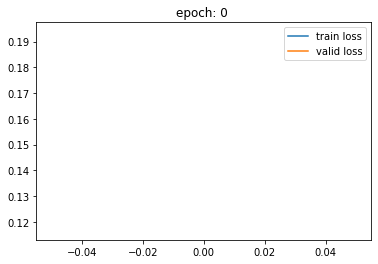

train loss:  0.1168214480082194
valid loss:  0.19365334510803223


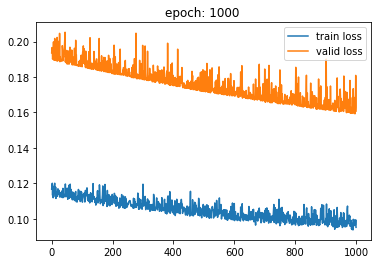

train loss:  0.09523039062817891
valid loss:  0.16076317429542542


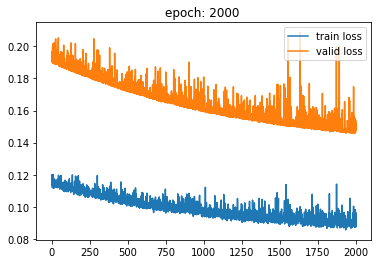

train loss:  0.08762386441230774
valid loss:  0.1519162654876709


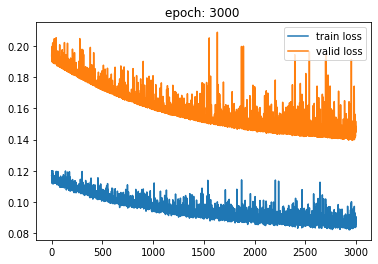

train loss:  0.08929068843523662
valid loss:  0.14654475450515747


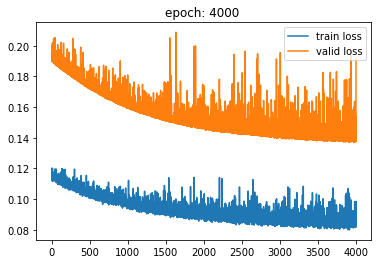

train loss:  0.09183972080548604
valid loss:  0.19175206124782562


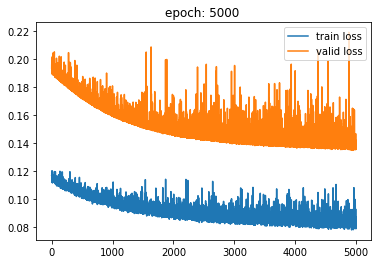

train loss:  0.0869146188100179
valid loss:  0.1381683498620987


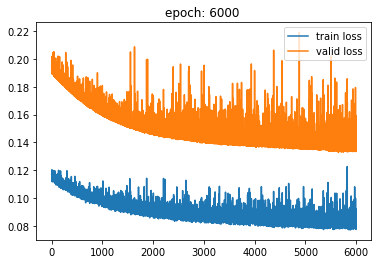

train loss:  0.08130621413389842
valid loss:  0.15898901224136353


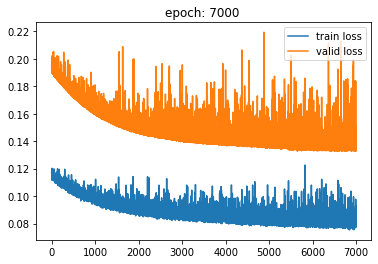

train loss:  0.07949153582255046
valid loss:  0.13538610935211182


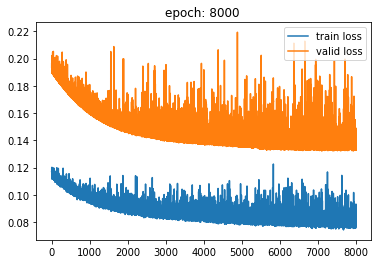

train loss:  0.078143576780955
valid loss:  0.13915306329727173


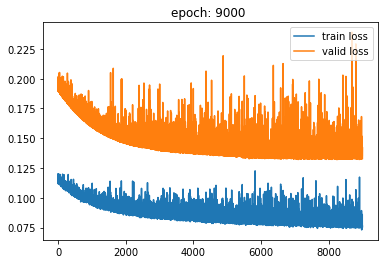

train loss:  0.0761278619368871
valid loss:  0.13308219611644745


In [13]:
# training the model
loss_train = np.array([])
loss_valid = np.array([])
alg = torch.optim.SGD(net.parameters(),lr=learning_rate*0.7) # sgd

for epoch in range(num_epochs-100):
  i=0
  l_epoch = 0
  for X,y in train_iter:
    i=i+1
    y_hat=net(X)
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()  

  loss_train = np.append(loss_train,l_epoch.detach().numpy()/i)

  i=0
  l_epoch = 0
  for X,y in valid_iter:
    i=i+1
    y_hat = net(X)
    l=loss(y_hat,y)  
    l_epoch+=l
  loss_valid = np.append(loss_valid,l_epoch.detach().numpy()/i)


  if epoch%1000 == 0:
    plt.plot(loss_train,label='train loss')
    plt.plot(loss_valid,label='valid loss')

    plt.legend(loc='upper right')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)

    print('train loss: ',loss_train[-1])
    print('valid loss: ',loss_valid[-1])

In [0]:
data_test = pd.read_csv('https://raw.githubusercontent.com/hufsbme/T10402101/master/ch4_multilayer_perceptron/sample_test.csv')
features_test, labels_test, country_test = data_test.iloc[:,L-28:L], data_test.iloc[:,-2], data_test.iloc[:,[1,2]]


country:  Singapore
label:  15641
predicted:  [11737]


Text(0.5, 1.0, 'Singapore')

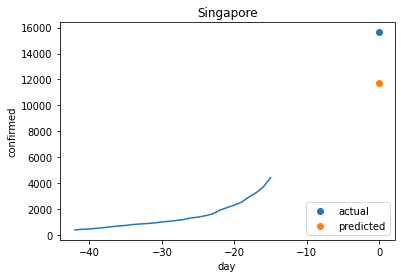

In [15]:
n=7
X = (torch.tensor(np.log(features_test.values+.1)).float())
y1 = net(X[n])
print('country: ',country_test.iloc[n,1])
print('label: ', labels_test[n])
print('predicted: ', np.int64(np.exp(y1.detach().numpy())))

plt.plot(np.arange(L-28,L,1),np.exp(X[n]))
plt.scatter(0,labels_test[n],label='actual')
plt.scatter(0,np.exp(y1.detach().numpy()),label='predicted')
plt.legend(loc='lower right')
plt.xlabel('day')
plt.ylabel('confirmed')
plt.title(country_test.iloc[n,1])